How to use:
- Pareto: Load the .csv file, transfer in this cwd, and let run
- Models: Adapt odt, let run here -> No Friedman Tes for that so far implemented!
- To get only ranks, return ranked_df in do_ranking

In [26]:
import pandas as pd
from scipy.stats import friedmanchisquare

In [27]:
# Method to Create Average rank of an df with 'dataset_name', 'classifier_name', accuracy
# The higher the accuracy, the better the rank!

def do_ranking(melted_df):

    def rank_accuracies(group):
        # Sort by accuracy
        sorted_group = group.sort_values('accuracy')
        # Compute ranks
        sorted_group['rank'] = sorted_group['accuracy'].rank(method='average')
        return sorted_group

    # Apply ranking within each dataset_name
    ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)

    # Compute average rank per classifier
    average_rank_per_classifier = ranked_df.groupby('classifier_name')['rank'].mean().reset_index()
    average_rank_per_classifier = average_rank_per_classifier.sort_values(by='rank', ascending=True).reset_index(drop=True)

    # Extract lists
    classifier_names = average_rank_per_classifier['classifier_name'].tolist()
    average_ranks = average_rank_per_classifier['rank'].tolist()

    # Display the lists
    print("Classifier Names:", classifier_names)
    print("Average Ranks:", average_ranks)

    # Return the DataFrame sorted by average rank
    return average_rank_per_classifier, classifier_names, average_ranks


In [28]:
def perform_friedman_test(df, alpha=0.05):
    """
    Perform the Friedman test to compare classifiers based on accuracy.

    Parameters:
    df (pd.DataFrame): DataFrame with columns 'classifier_name', 'dataset_name', and 'accuracy'.
    alpha (float): Significance level for the test. Default is 0.05.

    Returns:
    None: Prints the Friedman test results and interpretation.
    """
    # Pivot the DataFrame to have each dataset as rows and classifiers as columns
    df_pivot = df.pivot_table(index='dataset_name', columns='classifier_name', values='accuracy')

    # Drop any rows with NaN values (if there are any datasets without all classifiers)
    df_pivot = df_pivot.dropna()

    # Check the reshaped DataFrame
    print(df_pivot)

    # Perform the Friedman test
    classifiers = df_pivot.columns
    if len(classifiers) < 2:
        raise ValueError("At least two classifiers are required to perform the Friedman test.")
    
    # Extract accuracy values for each classifier
    test_args = [df_pivot[classifier] for classifier in classifiers]
    stat, p_value = friedmanchisquare(*test_args)

    # Print the Friedman test statistic and p-value
    print(f'Friedman test statistic: {stat}')
    print(f'p-value: {p_value}')

    # Interpret the result
    if p_value < alpha:
        print(f'There is a significant difference between the classifiers (alpha = {alpha}).')
    else:
        print(f'There is no significant difference between the classifiers (alpha = {alpha}).')

In [29]:
# Pre loaded Datasets of the pareto values in the proper form

#path = 'rmse_FLAML Results_count_df_with_0dval.csv'

path = 'msmape_FLAML Results_count_df.csv'

#path = 'rmse_FLAML Results_count_df.csv'  # -> best so far! see that dct is bad

#path = 'msmape_FLAML Results_count_df_with_0dval.csv'


df_perf = pd.read_csv(path, index_col=False)

# do_ranking ranks after lower values! lower error!
df_perf['accuracy'] = df_perf['accuracy'] * -1

ranked , classifiers, average_ranks = do_ranking(df_perf)
ranked

Classifier Names: ['dwt', 'dft', 'dct']
Average Ranks: [1.3125, 2.0, 2.6875]


/tmp/ipykernel_11234/874144397.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ranked_df = melted_df.groupby('dataset_name').apply(rank_accuracies).reset_index(drop=True)


,classifier_name,rank
0,dwt,1.3125
1,dft,2.0000
2,dct,2.6875


In [30]:
perform_friedman_test(df_perf, 0.05)

classifier_name             dct  dft  dwt
dataset_name                             
AppliancesEnergy           -3.0 -3.0 -4.0
BeijingPM25Quality         -3.0 -5.0 -6.0
BenzeneConcentration       -3.0 -2.0 -6.0
Covid3Month                -1.0 -1.0 -2.0
FloodModeling1              0.0 -1.0 -6.0
HouseholdPowerConsumption1 -2.0 -3.0 -3.0
IEEEPPG                     0.0 -1.0 -1.0
NewsTitleSentiment         -1.0 -2.0 -1.0
Friedman test statistic: 8.962962962962964
p-value: 0.011316635344033292
There is a significant difference between the classifiers (alpha = 0.05).


In [31]:
# Load the values form ods file

pd.set_option('display.max_rows', None)
# Load the ODS file
file_path = '/home/sim/Desktop/TS Extrinsic Regression/AutoML-Results.ods'
result_df = pd.read_excel(file_path, engine='odf', sheet_name='result')

# Transform the DataFrame to have classifier names as a single column
melted_df = result_df.melt(id_vars=['Dataset Name'], var_name='classifier_name', value_name='accuracy')

# Rename columns to match the desired output
melted_df = melted_df.rename(columns={'Dataset Name': 'dataset_name'})

# Drop any rows where accuracy is NaN
melted_df = melted_df.dropna(subset=['accuracy'])

# Now melted_df contains the required data
melted_df


,dataset_name,classifier_name,accuracy
0,AppliancesEnergy,AutoGluon,2.155978
1,BeijingPM10Quality,AutoGluon,108.381598
2,BeijingPM25Quality,AutoGluon,75.187533
3,BenzeneConcentration,AutoGluon,3.874767
4,Covid3Month,AutoGluon,0.040439
5,FloodModeling1,AutoGluon,0.013680
6,FloodModeling2,AutoGluon,0.019079
7,HouseholdPowerConsumption1,AutoGluon,145.957598
8,HouseholdPowerConsumption2,AutoGluon,46.925185
9,IEEEPPG,AutoGluon,25.574776


In [32]:
#ranked, classifiers, average_ranks = do_ranking(melted_df.copy())

1.1718505


/tmp/ipykernel_11234/3716765912.py:15: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = scoring.compute_CD(avranks,num_ds , alpha='0.05', test=test)
/tmp/ipykernel_11234/3716765912.py:17: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)


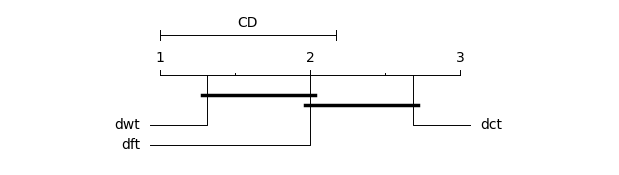

In [33]:
# Create the Cd-Diagram
import importlib
from Orange.evaluation import scoring
_ = importlib.reload( scoring )

names = classifiers
avranks = average_ranks

test = 'nemenyi'
#test = 'bonferroni-dunn'

num_ds = 8
#num_ds = 11

cd = scoring.compute_CD(avranks,num_ds , alpha='0.05', test=test) 
print(cd)
scoring.graph_ranks(avranks, names, cd, width=6, textspace=1.5)